In [4]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [6]:
import addict
import copy
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from importlib import reload
from tqdm.notebook import tqdm
from typing import List, Dict, Tuple

import celeri

plt.rcParams[
    "text.usetex"
] = False  # Plotting the global model is much much faster with tex fonts turned off

# Read in data files, create storage dictionaries, and do basic processing

In [68]:
# Western North America example
# command_file_name = "../data/command/western_north_america_command.json"
# Japan model
command_file_name = "../data/command/japan_command.json"

In [69]:
command = celeri.get_command(command_file_name)
celeri.create_output_folder(command)
logger = celeri.get_logger(command)
segment, block, meshes, station, mogi, sar = celeri.read_data(command)
station = celeri.process_station(station, command)
segment = celeri.process_segment(segment, command, meshes)
# segment = celeri.snap_segments(segment, meshes)
sar = celeri.process_sar(sar, command)
closure, block = celeri.assign_block_labels(segment, station, block, mogi, sar)
assembly = addict.Dict()
operators = addict.Dict()
operators.meshes = [addict.Dict()] * len(meshes)
assembly = celeri.merge_geodetic_data(
    assembly, station, sar
)  # Not sure this works correctly

2024-11-06 11:14:14.010 | INFO     | celeri.celeri:get_logger:7543 - Read: ../data/command/japan_command.json
2024-11-06 11:14:14.010 | INFO     | celeri.celeri:get_logger:7544 - RUN_NAME: 0000000121
2024-11-06 11:14:14.011 | INFO     | celeri.celeri:get_logger:7545 - Write log file: ../runs/0000000121/0000000121.log
2024-11-06 11:14:14.012 | INFO     | celeri.celeri:read_data:451 - Reading data files
2024-11-06 11:14:14.015 | SUCCESS  | celeri.celeri:read_data:455 - Read: ../data/segment/qp_japan_segment.csv
2024-11-06 11:14:14.017 | SUCCESS  | celeri.celeri:read_data:460 - Read: ../data/block/japan_block.csv
2024-11-06 11:14:14.018 | SUCCESS  | celeri.celeri:read_data:467 - Read: ../data/mesh/japan_mesh_parameters.json

2024-11-06 11:14:14.075 | SUCCESS  | celeri.celeri:read_mesh:446 - Read: ../data/mesh/nankai.msh

2024-11-06 11:14:14.083 | SUCCESS  | celeri.celeri:read_mesh:446 - Read: ../data/mesh/japan.msh

2024-11-06 11:14:14.094 | SUCCESS  | celeri.celeri:read_mesh:446 - Read: 

# Get elastic operators and TDE smoothing operators

In [70]:
# Get all elastic operators for segments and TDEs
celeri.get_elastic_operators(operators, meshes, segment, station, command)

# Get TDE smoothing operators
celeri.get_all_mesh_smoothing_matrices(meshes, operators)

2024-11-06 11:14:16.140 | INFO     | celeri.celeri:get_elastic_operators:2038 - Using precomputed elastic operators


# Calculate non-elastic operators

In [71]:
operators.rotation_to_velocities = celeri.get_rotation_to_velocities_partials(
    station, len(block)
)
operators.global_float_block_rotation = celeri.get_global_float_block_rotation_partials(
    station
)
assembly, operators.block_motion_constraints = celeri.get_block_motion_constraints(
    assembly, block, command
)
assembly, operators.slip_rate_constraints = celeri.get_slip_rate_constraints(
    assembly, segment, block, command
)
operators.rotation_to_slip_rate = celeri.get_rotation_to_slip_rate_partials(
    segment, block
)

(
    operators.block_strain_rate_to_velocities,
    strain_rate_block_index,
) = celeri.get_block_strain_rate_to_velocities_partials(block, station, segment)
operators.mogi_to_velocities = celeri.get_mogi_to_velocities_partials(
    mogi, station, command
)
celeri.get_tde_slip_rate_constraints(meshes, operators)
celeri.get_tde_coupling_constraints(meshes, segment, block, operators)

2024-11-06 11:14:18.725 | INFO     | celeri.celeri:get_slip_rate_constraints:3352 - No slip rate constraints


# Plot input data

In [ ]:
celeri.plot_input_summary(
    command,
    segment,
    station,
    block,
    meshes,
    mogi,
    sar,
    lon_range=command.lon_range,
    lat_range=command.lat_range,
    quiver_scale=1e2,
)

# Sketching out the assembly of the block model system

$$
\begin{bmatrix}
    \mathrm{geodetic \; velocities} \\
    \mathrm{plate \; rotation \; constraints} \\
    \mathrm{slip \; rate \; constraints} \\
    \mathrm{TDE \; smoothing \; pseudodata = 0} \\
    \mathrm{TDE \; rate \; constraints} \\
    \mathrm{TDE \; coupling \; constraints = 0} \\
    \mathrm{InSAR \; LOS \; changes} 
\end{bmatrix}
=
\begin{bmatrix}
    \mathrm{(rotations-elastic \; segments) \; to \; velocities} & \mathrm{TDEs \; to \; velocities} & \mathrm{block \; strain \; rate \; to \; velocities} & \mathrm{Mogi \; to \; velocities}\\
    \mathrm{identities}                                          & 0                                   & 0 \\
    \mathrm{plate \; rotations \; to \; slip \; rates}           & 0                                   & 0 \\
    0                                                            & \mathrm{TDE \; smoothing \; matrix} & 0 \\
    0                                                            & \mathrm{identities}                 & 0 \\
    -\phi(\mathrm{plate \; rotations \; to \; TDE \; slip \; rates)}    & \mathrm{identities}                & 0 \\
    \mathrm{(rotations-elastic \; segments) \; to \; LOS}        & \mathrm{TDEs \; to \; LOS}          & \mathrm{block \; strain \; rate \; to \; velocities}
\end{bmatrix}
\begin{bmatrix}
    \mathrm{plate \; rotation \; rates} \\
    \mathrm{TDE \; slip \; rates} \\
    \mathrm{block \; strain \; rates} \\
    \mathrm{Mogi \; rates}
\end{bmatrix}
$$

# Estimate block model parameters (dense)

In [72]:
index, estimation = celeri.assemble_and_solve_dense(
    command, assembly, operators, station, block, meshes, mogi
)
celeri.post_process_estimation(estimation, operators, station, index)
celeri.write_output(command, estimation, station, segment, block, meshes, mogi)

# Plot model summary

In [ ]:
celeri.plot_estimation_summary(
    command,
    segment,
    station,
    meshes,
    estimation,
    lon_range=command.lon_range,
    lat_range=command.lat_range,
    quiver_scale=1e2,
)

### Testing triangular coupling calculations

In [79]:
i = 1
# Calculate partials
tricoup = celeri.get_rotation_to_tri_slip_rate_partials(meshes[i], i, segment, block)
# Do the projection of block motions
trislip = tricoup @ estimation.state_vector[0 : 3 * index.n_blocks]
# Isolate components
tristrike = trislip[0::3]
tridip = trislip[1::3]
tritens = trislip[2::3]
# Identify segments closest to each element
csi = np.unique(meshes[i].closest_segment_idx)

#### Visualize projected slip rates

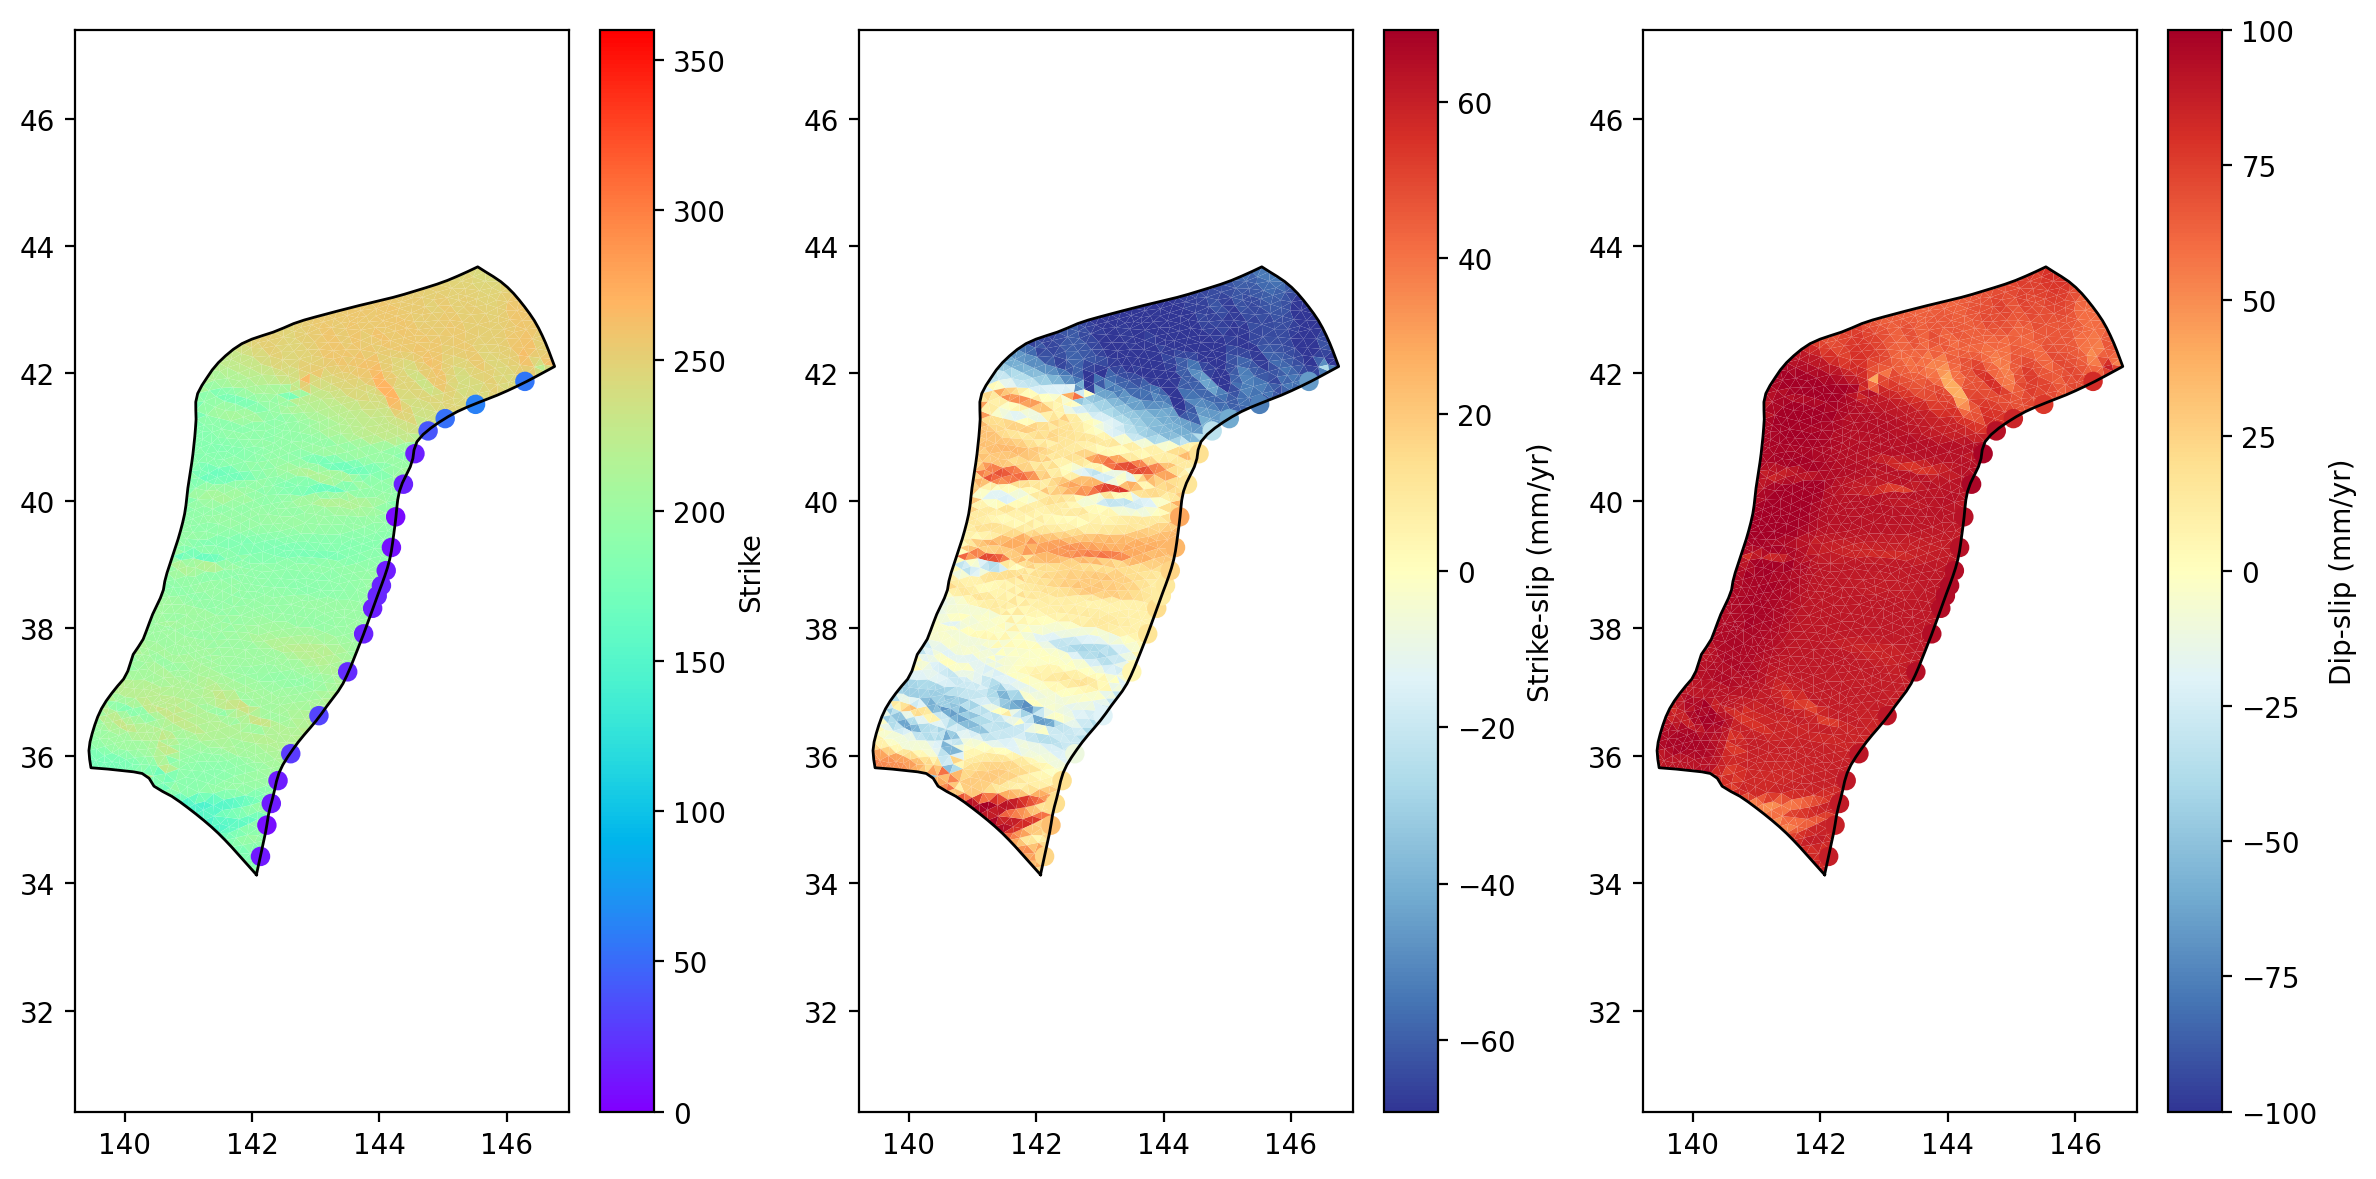

In [80]:
# plt.close('all')
import matplotlib
# %matplotlib widget

tri_strike = np.array(meshes[i].strike)
tri_strike[meshes[i].strike > 180] -= 180

import pyproj
GEOID = pyproj.Geod(ellps="WGS84")
segment_azimuth = np.zeros_like(segment.lon1)
for j in range(len(segment.lon1)):
    segment_azimuth[j], _, _ = GEOID.inv(segment.lon1[j], segment.lat1[j], segment.lon2[j], segment.lat2[j])
rhrstrike = segment_azimuth + 180

seg_flip = np.zeros_like(segment.lon1)
seg_flip[segment.lat2 < segment.lat1] = -1000
import matplotlib.colors as colors
fig1, ax = plt.subplots(1, 3, figsize=(12, 6))

fill_value0 = meshes[i].strike
# fill_value0 = tri_strike
# fill_value0[fill_value0 > 180] -= 180
# fill_value_range0 = [np.min(fill_value0), np.max(fill_value0)]
fill_value_range0 = [0, 360]
x_coords = meshes[i].points[:, 0]
y_coords = meshes[i].points[:, 1]
vertex_array = np.asarray(meshes[i].verts)
xy = np.c_[x_coords, y_coords]
verts = xy[vertex_array]
pc0 = matplotlib.collections.PolyCollection(
    verts, edgecolor="none", cmap="rainbow"
)
pc0.set_array(
    fill_value0
)
pc0.set_clim(fill_value_range0)
ax[0].add_collection(pc0)
ax[0].scatter(segment.mid_lon[csi], segment.mid_lat[csi], vmin=fill_value_range0[0], vmax=fill_value_range0[1], c=segment.azimuth[csi], cmap="rainbow")
plt.colorbar(pc0, label="Strike", ax=ax[0])
# Add mesh edge
x_edge = x_coords[meshes[i].ordered_edge_nodes[:, 0]]
y_edge = y_coords[meshes[i].ordered_edge_nodes[:, 0]]
x_edge = np.append(x_edge, x_coords[meshes[0].ordered_edge_nodes[0, 0]])
y_edge = np.append(y_edge, y_coords[meshes[0].ordered_edge_nodes[0, 0]])
ax[0].plot(x_edge, y_edge, color="black", linewidth=1)
ax[0].axis('equal')

fill_value1 = tristrike
fill_value_range1 = [-np.max(fill_value1), np.max(fill_value1)]

pc1 = matplotlib.collections.PolyCollection(
    verts, edgecolor="none", cmap="RdYlBu_r"
)
pc1.set_array(
    fill_value1
)
pc1.set_clim(fill_value_range1)
ax[1].add_collection(pc1)
ax[1].scatter(segment.mid_lon[csi], segment.mid_lat[csi], vmin=fill_value_range1[0], vmax=fill_value_range1[1], c=estimation.strike_slip_rates[csi], cmap="RdYlBu_r")
plt.colorbar(pc1, label="Strike-slip (mm/yr)", ax=ax[1])
# Add mesh edge
ax[1].plot(x_edge, y_edge, color="black", linewidth=1)
ax[1].axis('equal')


fill_value2 = tridip
fill_value_range2 = [-100, 100]
pc2 = matplotlib.collections.PolyCollection(
    verts, edgecolor="none", cmap="RdYlBu_r"
)
pc2.set_array(
    fill_value2
)

ax[2].add_collection(pc2)
pc2.set_clim(fill_value_range2)
ax[2].scatter(segment.mid_lon[csi], segment.mid_lat[csi], vmin=fill_value_range2[0], vmax=fill_value_range2[1], c=estimation.dip_slip_rates[csi], cmap="RdYlBu_r")
plt.colorbar(pc2, label="Dip-slip (mm/yr)", ax=ax[2])
# Add mesh edge
ax[2].plot(x_edge, y_edge, color="black", linewidth=1)
ax[2].axis('equal')

fig1.tight_layout()
# print(estimation.strike_slip_rates[csi])
# print(estimation.tensile_slip_rates[csi])
# print(segment.azimuth[csi])


### Japan Trench
- `sign_corr` giving -1 for `tristrike > 90`: essential for flipping sign of the few elements whose strikes < 180º
- `ew_switch = 1` gives all correct slip sense. Previously problematic elements were those whose strikes < 180º, but those are resolved with `sign_corr`

### Nankai Trough
- `sign_corr = 1` is essential for flipping sign of slips in the "nose" regions where strike > 270º
    - These are elements that would get negated with the regular `sign_corr` analysis
- `ew_switch = 1` gives correct slip sense *except* on a few elements whose strike are < 180º, which is inconsistent with Japan Trench 

- When `sign_corr` modulates `tristrike > 90`, noses flip to wrong sense of slip, but isolated elements with strikes < 180º get correct slip sense 

### Sagami Trough
- `sign_corr` giving -1 for `tristrike > 90` gives mostly correct slip sense, except in panels where it seems that strike > 270º and nearest segment strike < 270º, so this is a case where something like `ew_switch` is needed 

### Debugging strain rate calculations

In [ ]:
strain_rate_block_index[0]

centroid_lon = 133.3318559095709
centroid_lat = 34.42960594634139

lonrange = np.arange(centroid_lon - 1, centroid_lon + 1, 0.05)
latrange = np.arange(centroid_lat - 1, centroid_lat + 1, 0.05)

fslon, fslat = np.meshgrid(lonrange, latrange)

fakesta = pd.DataFrame(columns=["lon", "lat", "block_label"])
fakesta.lon = np.reshape(fslon, -1)
fakesta.lat = np.reshape(fslat, -1)
fakesta.block_label = 10*np.ones_like(fakesta.lon)

strain_partials, _ = celeri.get_block_strain_rate_to_velocities_partials(block, fakesta, segment)

strain_comp = [0, 1, 0]

strainvels = strain_partials@strain_comp

fig, ax = plt.subplots()
ax.quiver(fakesta.lon, fakesta.lat, strainvels[0::3], strainvels[1::3])
plt.show()



2024-11-01 16:14:33.966 | SUCCESS  | celeri.celeri:read_mesh:446 - Read: ../data/mesh/japan.msh
dict_keys(['file_name', 'points', 'verts', 'lon1', 'lon2', 'lon3', 'lat1', 'lat2', 'lat3', 'dep1', 'dep2', 'dep3', 'centroids', 'x1', 'y1', 'z1', 'x2', 'y2', 'z2', 'x3', 'y3', 'z3', 'x_centroid', 'y_centroid', 'z_centroid', 'lon_centroid', 'lat_centroid', 'nv', 'strike', 'dip', 'dip_flag', 'n_tde', 'areas'])


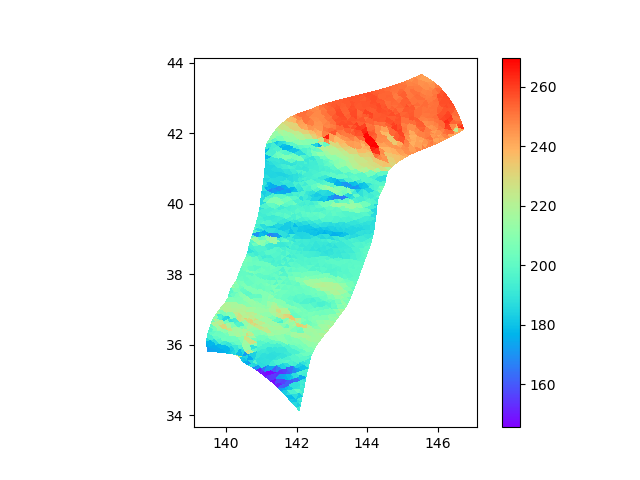

In [17]:
japant = celeri.read_mesh("../data/mesh/japan.msh")
print(japant.keys())
fig, ax = plt.subplots()
so = ax.tripcolor(japant.points[:, 0], japant.points[:, 1], japant.verts, japant.strike, cmap="rainbow")
plt.colorbar(so)
ax.set_aspect("equal")
plt.show()


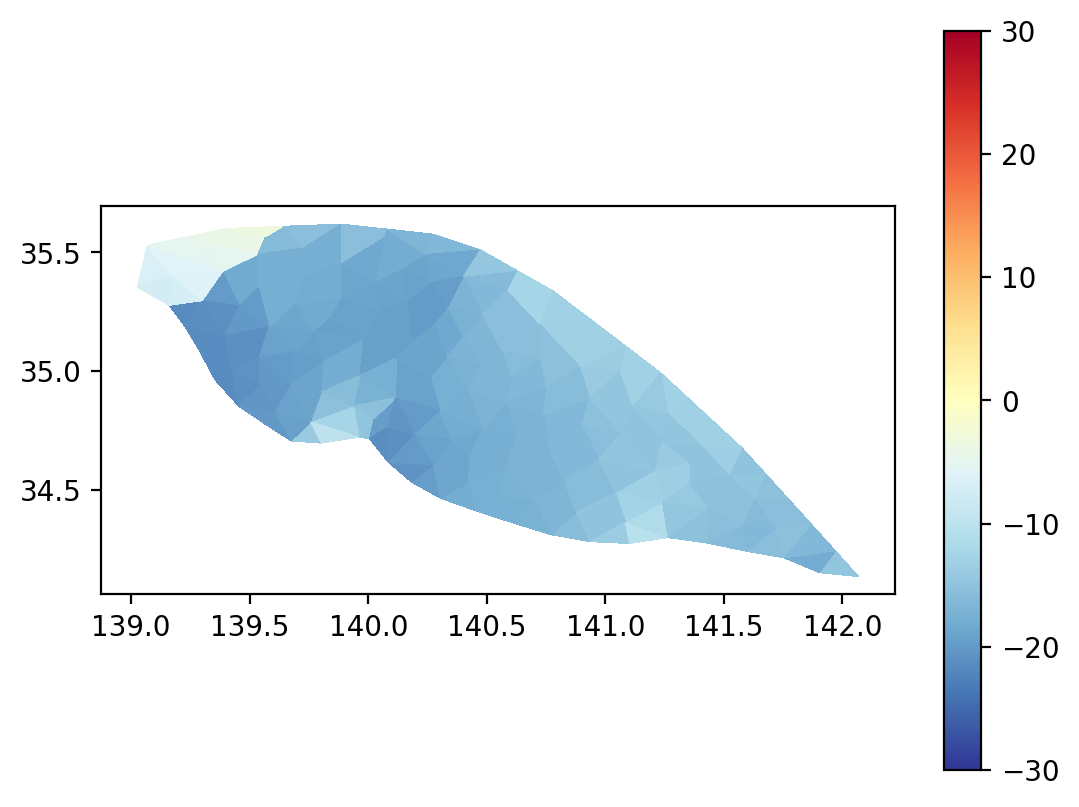

In [78]:
fig, ax = plt.subplots()
so = ax.tripcolor(meshes[2].points[:, 0], meshes[2].points[:, 1], meshes[2].verts, tristrike, vmin=-30, vmax=30, cmap="RdYlBu_r")
plt.colorbar(so)
ax.set_aspect("equal")
plt.show()

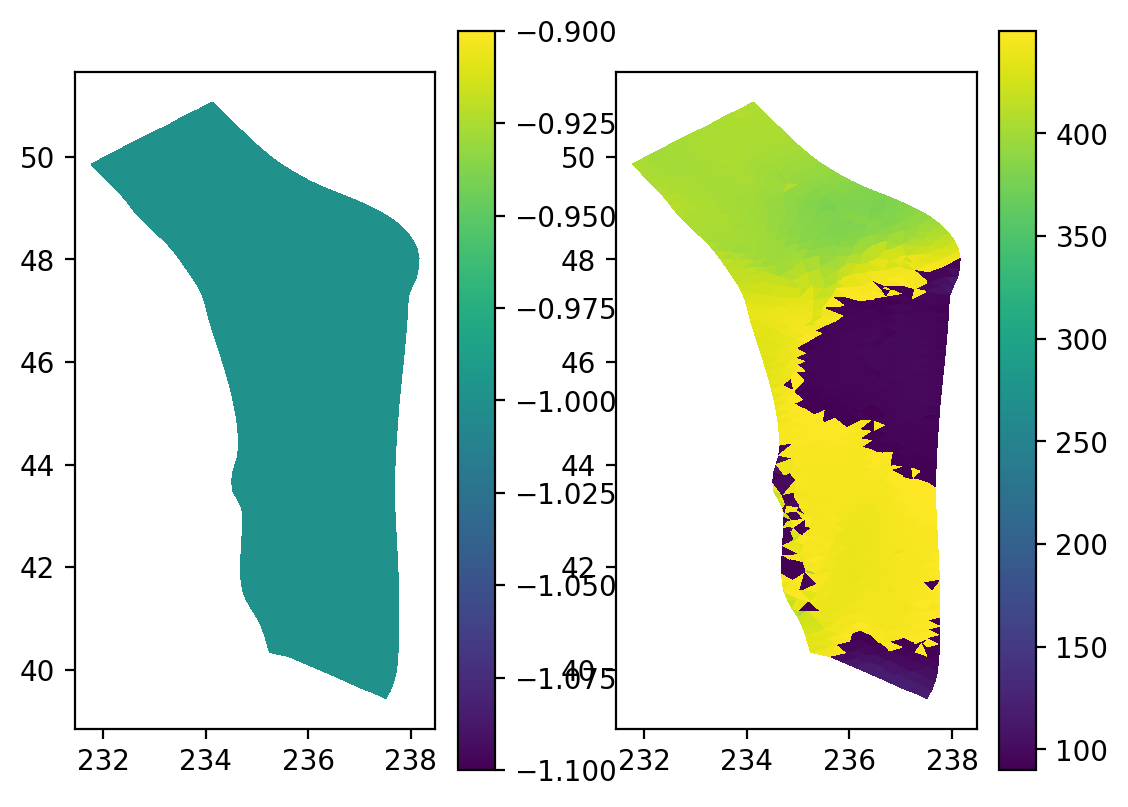

[[ 0.         -0.          0.39848057]
 [ 0.         -0.          0.19618147]
 [ 0.         -0.          0.21837776]
 [ 0.         -0.          0.20792049]
 [ 0.         -0.          0.16461206]
 [ 0.         -0.          0.10392099]
 [ 0.         -0.          0.01102531]
 [ 0.         -0.          0.13060374]
 [ 0.         -0.          0.2029185 ]
 [ 0.         -0.          0.06027931]
 [ 0.         -0.          0.32174092]
 [ 0.         -0.          0.00944505]
 [ 0.         -0.          0.34478484]
 [ 0.         -0.          0.22339549]
 [ 0.         -0.          0.53966843]
 [ 0.         -0.          0.46513094]
 [ 0.         -0.          0.54996279]
 [ 0.         -0.          0.57050979]
 [ 0.         -0.          0.45903533]]


In [59]:
seg_dip_dir = np.array(segment.azimuth)
seg_dip_dir = seg_dip_dir + np.sign(np.cos(np.deg2rad(segment.dip))) * 90
seg_dip_dir_x = np.sin(np.deg2rad(90 - seg_dip_dir))
seg_dip_dir_y = np.cos(np.deg2rad(90 - seg_dip_dir))
seg_comps = np.vstack([seg_dip_dir_x[:], seg_dip_dir_y[:], np.zeros_like(seg_dip_dir_x)]).T
tri_dip_dir = meshes[0].strike + 90
tri_dip_dir_x = np.cos(np.deg2rad(90 - tri_dip_dir))
tri_dip_dir_y = np.sin(np.deg2rad(90 - tri_dip_dir))
tri_comps = np.vstack([tri_dip_dir_x[:], tri_dip_dir_y[:], np.zeros_like(tri_dip_dir_x)]).T
north_tri_cross = np.cross(
    np.array([0, 1, 0]),
    tri_comps,
)
north_seg_cross = np.cross(
    np.array([0, 1, 0]),
    seg_comps,
)

fig, ax = plt.subplots(1, 2)
so = ax[0].tripcolor(meshes[0].points[:, 0], meshes[0].points[:, 1], meshes[0].verts, np.sign(north_tri_cross[:, 2]))
ax[0].set_aspect("equal")
plt.colorbar(so)
do = ax[1].tripcolor(meshes[0].points[:, 0], meshes[0].points[:, 1], meshes[0].verts, tri_dip_dir)
ax[1].set_aspect("equal")
plt.colorbar(do)
plt.show()
print(north_seg_cross[csi])